In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import multivariate_normal as mvn
import seaborn as sns
import sys
sys.path.append(os.path.abspath('../../utils'))
from utils_preproc import get_fenceposts
%matplotlib inline

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.005-seed=109-n_states=10-batch_size=-1-lamb=50.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid AUC_mean  test AUC_mean  train_AUPRC_mean  \
0             1.0        0.990267            1.0               1.0   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid AUC_0  \
0          0.987926              1.0          1.0            1.0          1.0   

   valid_AUPRC_0  ...  test AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0            1.0  ...         1.0           1.0          1.0            1.0   

   valid AUC_3  valid_AUPRC_3  test AUC_3  test_AUPRC_3  \
0     0.996622       0.986111         1.0           1.0   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 columns]
----

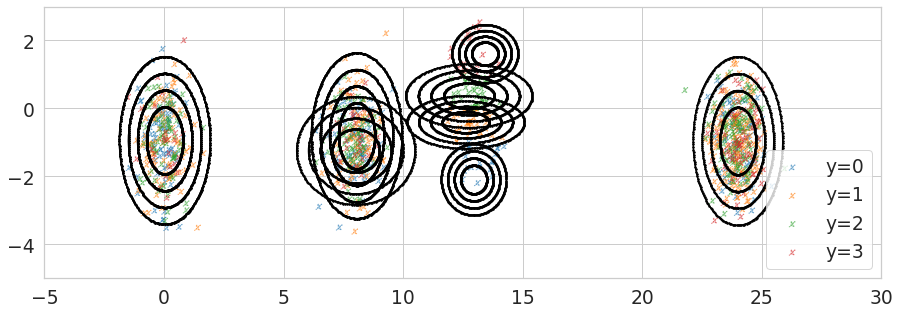

In [47]:
fits_dir = os.path.abspath('../ordinal_training_logs/pchmm/')

missing_handling_aka_dict = {'no_imp' : 'no imputation (ours)',
                            'ffill_imp' : 'forward fill imputation',
                            'mean_imp' : 'mean imputation'}

for missing_handling in ['no_imp']:
    for perc_obs in ['100']:
        all_fits_csvs = glob.glob(os.path.join(fits_dir, "final_perf*pchmm-*missing_handling=%s-*perc_obs=%s-*lr=0.005-seed=109*n_states=10-*lamb=50*.csv"%(missing_handling, perc_obs)))
#         all_fits_csvs = glob.glob(os.path.join(fits_dir, "final_perf*pchmm-*missing_handling=%s-*perc_obs=%s-*n_states=*lamb=*.csv"%(missing_handling, perc_obs)))
        losses_per_fit_np = np.zeros(len(all_fits_csvs))
        auc_per_fit_np = np.zeros(len(all_fits_csvs))
        
        
        for ii, fit_csv in enumerate(all_fits_csvs):
            try:
                fit_df = pd.read_csv(fit_csv)
                hist_csv = fit_csv.replace('final_perf_', '')
                hist_df = pd.read_csv(hist_csv)
                lamb = int(hist_csv.replace('.csv', '').split('lamb=')[-1])
                curr_loss = hist_df['val_hmm_model_loss'].to_numpy()[-1] + (hist_df['val_predictor_loss'].to_numpy()[-1])/lamb
                val_auc = fit_df['test AUC_mean'].values[0]
                losses_per_fit_np[ii]=curr_loss
                auc_per_fit_np[ii]=val_auc
            except:
                losses_per_fit_np[ii]=np.inf
                auc_per_fit_np[ii] = 0
        
        sorted_losses_inds = np.argsort(losses_per_fit_np)
        sorted_auc_inds = np.argsort(auc_per_fit_np)
        for kk in range(1):
#             best_fit_ind = sorted_losses_inds[kk]
            best_fit_ind = sorted_auc_inds[-1-kk]
        
        
    #         best_fit_ind = np.argmin(losses_per_fit_np)
    #         best_fit_ind = np.argmax(auc_per_fit_np)
            best_fit_csv = all_fits_csvs[best_fit_ind]

            print(best_fit_csv)
            #get the mus and covariances of the best fit
            best_fit_mu = best_fit_csv.replace(".csv", "-fit-mu.npy").replace("final_perf_", "")
            best_fit_cov = best_fit_csv.replace(".csv", "-fit-cov.npy").replace("final_perf_", "")
            best_fit_eta = best_fit_csv.replace(".csv", "-fit-eta.npy").replace("final_perf_", "")


    #         final_perf_csv = os.path.join(fits_dir, 'final_perf_'+best_fit_csv.split('/')[-1])
            final_perf_df = pd.read_csv(best_fit_csv)
            final_hist_df = pd.read_csv(best_fit_csv.replace('final_perf_', ''))

            final_perf_df['model'] = 'PCHMM %s'%missing_handling_aka_dict[missing_handling]
            final_perf_df['perc_obs'] = perc_obs
            print('--------------------------------------')
            print('MISSING HANDLING = %s perc observed = %s'%(missing_handling, perc_obs))
            print(final_perf_df)
            print('--------------------------------------')


            mu_all = np.load(best_fit_mu)
            cov_all = np.load(best_fit_cov)
            eta_all = np.load(best_fit_eta)

            visualize2D_new(data_DTN=data_DTN, y_N=y_N, mu_all=mu_all, cov_all=cov_all, levels=3, 
                    markerlist=['$x$', '$o$'], alpha=0.3, 
                    missing_handling=missing_handling,
                   perc_obs=perc_obs, 
                            savename='toydata_fits.png'
                           )

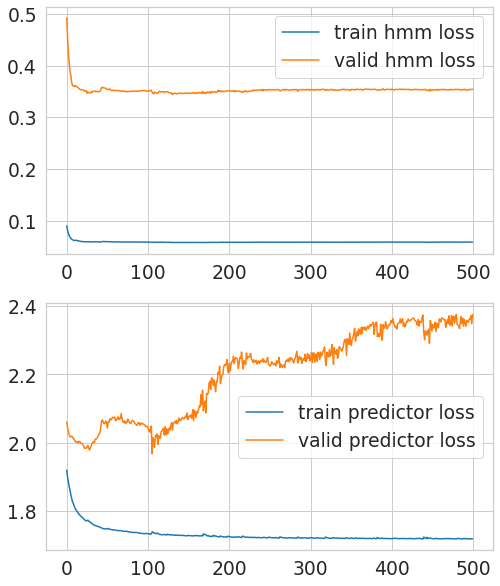

In [40]:
f, axs = plt.subplots(2, 1, figsize=(8, 10))

lamb = int(best_fit_csv.replace('.csv', '').split('lamb=')[-1])
epochs = range(len(final_hist_df))
train_hmm_loss = final_hist_df['hmm_model_loss'].values
val_hmm_loss = final_hist_df['val_hmm_model_loss'].values

train_predictor_loss = final_hist_df['predictor_loss'].values/lamb
val_predictor_loss = final_hist_df['val_predictor_loss'].values/lamb

axs[0].plot(epochs, train_hmm_loss, label='train hmm loss')
axs[0].plot(epochs, val_hmm_loss, label='valid hmm loss')

axs[1].plot(epochs, train_predictor_loss, label='train predictor loss')
axs[1].plot(epochs, val_predictor_loss, label='valid predictor loss')

for ax in axs:
    ax.legend()

In [28]:
fit_df

,train_AUC_mean,valid AUC_mean,test AUC_mean,train_AUPRC_mean,valid_AUPRC_mean,test_AUPRC_mean,train_AUC_0,train_AUPRC_0,valid AUC_0,valid_AUPRC_0,...,valid AUC_1,valid_AUPRC_1,test AUC_1,test_AUPRC_1,train_AUC_2,train_AUPRC_2,valid AUC_2,valid_AUPRC_2,test AUC_2,test_AUPRC_2
0,0.854695,0.84,0.825002,0.658233,0.743055,0.667739,1.0,1.0,1.0,1.0,...,0.902222,0.825208,0.882698,0.728304,0.726023,0.372571,0.617778,0.403957,0.592308,0.274914


In [67]:
eta_all

array([[ -2.46],
       [ -3.89],
       [ 54.8 ],
       [-30.51],
       [ 27.54],
       [ -3.87],
       [ -2.34],
       [-33.96],
       [  0.73]], dtype=float32)

## Plot the best fits

In [3]:
def visualize2D_new(data_DTN=None, y_N=None, mu_all=None, cov_all=None, levels=3, 
                colorlist=['salmon', 'blue'], markerlist=['$x$', '$o$'], alpha=0.3, 
                    missing_handling="", perc_obs='20', savename=None):
    
    f, ax = plt.subplots(figsize=(15, 5))
    sns.set_context("notebook", font_scale=1.7)
    sns.set_style("whitegrid")
    
    ordinal_labels_num = np.max(y_N)+1
    for ordinal_label in range(ordinal_labels_num):
        inds_curr_label = y_N==ordinal_label
        feature_vals_ND_labels_y = data_DTN[:, :, inds_curr_label]

        # plot time series sequence of example with label 0 and 1
        ax.scatter(feature_vals_ND_labels_y[0, :], feature_vals_ND_labels_y[1, :],
                    marker='$x$', linestyle=':', alpha=0.5, label=f'y={ordinal_label}')
        
        
        ax.legend()
    fontsize=10
    
    ax.set_xlim([-5, 30])
    ax.set_ylim([-5, 3])
    
    
    for ii in range(mu_all.shape[0]):
        D = len(mu_all[ii])
        cov_DD = np.diag(cov_all[ii, :])
        mu_D = mu_all[ii]
        
        # Decompose cov matrix into eigenvalues "lambda[d]" and eigenvectors "U[:,d]"
        lambda_D, U_DD = np.linalg.eig(cov_DD)

        # Verify orthonormal
        assert np.allclose(np.eye(D), np.dot(U_DD, U_DD.T))
        # View eigenvector matrix as a rotation transformation
        rot_DD = U_DD

        # Prep for plotting elliptical contours
        # by creating grid of G different (x,y) points along perfect circle
        # Recall that a perfect circle is swept by considering all radians between [-pi, +pi]
        unit_circle_radian_step_size=0.03
        t_G = np.arange(-np.pi, np.pi, unit_circle_radian_step_size)
        x_G = np.sin(t_G)
        y_G = np.cos(t_G)
        Zcirc_DG = np.vstack([x_G, y_G])

        # Warp circle into ellipse defined by Sigma's eigenvectors
        # Rescale according to eigenvalues
        Zellipse_DG = np.sqrt(lambda_D)[:,np.newaxis] * Zcirc_DG
        # Rotate according to eigenvectors
        Zrotellipse_DG = np.dot(rot_DD, Zellipse_DG)
        
        radius_lengths=[1.0, 1.5, 2.0, 2.5]
        
        # Plot contour lines across several radius lengths
        for r in radius_lengths:
            Z_DG = r * Zrotellipse_DG + mu_D[:, np.newaxis]
            plt.plot(
                Z_DG[0], Z_DG[1], '.-',
                color='k',
                markersize=3.0,
                markerfacecolor='k',
                markeredgecolor='k')
            
        if savename is not None:
            f.savefig(savename, bbox_inches='tight')
    plt.show()

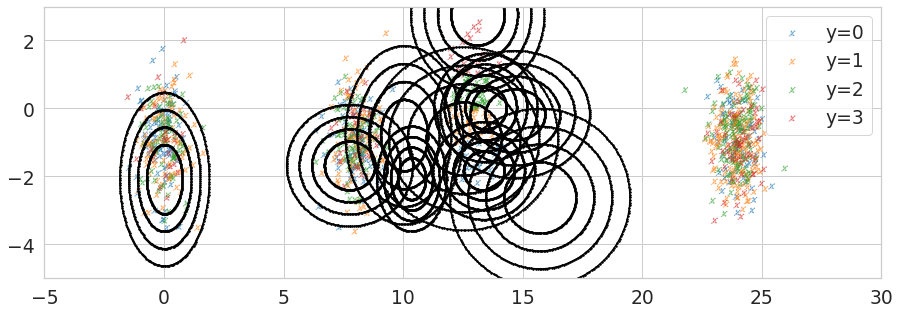

In [30]:
mu_all = np.load(best_fit_mu)
cov_all = np.load(best_fit_cov)
eta_all = np.load(best_fit_eta)


# mu_all = np.array([[12.59,  -0.5],
#        [24.  , -0.96],
#        [12.54,  1.81],
#        [12.97, -1.68],
#        [ 7.89, -1.03],
#        [ 0.02, -0.93],
#        [12.52,  0.44],
#        [ 7.9 , -1.01]])


# cov_all = np.array([[0.63, 0.07],
#        [0.56, 0.98],
#        [3.22, 0.49],
#        [0.31, 0.14],
#        [0.74, 1.64],
#        [0.55, 0.96],
#        [1.02, 0.3 ],
#        [0.75, 1.62]])

data_dir = os.path.abspath('../ordinal_data')
# get the data
features_df = pd.read_csv(os.path.join(data_dir, "features_2d_per_tstep_%s_observed=%s_perc.csv"%(missing_handling, perc_obs)))
outcomes_df = pd.read_csv(os.path.join(data_dir, "outcomes_per_seq.csv"))

features_outcomes_df = pd.merge(features_df, outcomes_df, on='sequence_id')

# get the data in D x T x N form
data_DTN_list = []
id_cols = ['sequence_id']
fp = get_fenceposts(features_outcomes_df, id_cols)
n_rows = len(fp)-1
feature_cols = ['temperature_1', 'temperature_2']
features_arr = features_outcomes_df[feature_cols].values
for p in range(n_rows):
    data_DTN_list.append(features_arr[fp[p]:fp[p+1], :])

data_DTN = np.stack(data_DTN_list).T
features_outcomes_df.drop_duplicates(subset=id_cols, inplace=True)
y_N = features_outcomes_df['ordinal_label'].values

visualize2D_new(data_DTN=data_DTN, y_N=y_N, mu_all=mu_all, cov_all=cov_all, levels=3, 
                markerlist=['$x$', '$o$'], alpha=0.3, 
                missing_handling=missing_handling,
               perc_obs=perc_obs)


In [47]:
np.set_printoptions(suppress=True, precision=2)

In [48]:
mu_all

array([[12.59,  0.03],
       [24.  , -0.96],
       [15.54,  1.81],
       [12.97, -1.68],
       [ 7.89, -1.03],
       [ 0.02, -0.93],
       [16.52,  1.14],
       [ 7.9 , -1.01]], dtype=float32)

In [49]:
cov_all

array([[0.63, 0.22],
       [0.56, 0.98],
       [3.22, 0.49],
       [0.31, 0.14],
       [0.74, 1.64],
       [0.55, 0.96],
       [1.82, 4.3 ],
       [0.75, 1.62]], dtype=float32)

In [17]:
eta_all

array([[ -3.0863848 ],
       [ -3.1961846 ],
       [ 50.535564  ],
       [-28.766712  ],
       [ 26.108828  ],
       [ -3.1526632 ],
       [ -2.519368  ],
       [-33.192657  ],
       [  0.43120778]], dtype=float32)

In [167]:
fits_dir

'/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm'

In [29]:
!rm /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm/*pchmm-missing_handling=no_imp-perc_obs=100-lr=0.05-seed=786-batch_size=-1-lamb=1.*

In [43]:
np.random.choice(1000, 100)

array([328, 153, 763, 958, 132, 608, 697, 906, 975, 822, 628, 123,  30,
       672, 903, 786, 497, 268, 799, 593, 833, 986, 124, 125, 476, 536,
       360, 270, 224, 365, 432, 954, 670, 104,  99, 648, 732, 734, 567,
       817, 140, 194, 176, 318, 171, 317, 148, 840, 796, 675, 355, 800,
       839, 415, 967, 730, 224,  32,  54, 365, 242, 959, 728, 329, 291,
        31, 107, 154, 777, 788, 247, 974, 920,  84, 274,  48, 723, 106,
       636, 344, 203, 984, 144,  66,  64, 833, 313,  37, 776, 539, 887,
       712, 915, 813, 571,  27, 401, 226, 358, 227])

In [119]:
sorted_losses_inds = np.argsort(losses_per_fit_np)

In [120]:
np.array(auc_per_fit_np)[sorted_losses_inds]

array([0.82213439, 0.86166008, 0.78656126, 0.88932806, 0.73715415,
       0.79249012, 0.82411067, 0.81027668, 0.81225296, 0.7312253 ,
       0.81027668, 0.92687747, 0.82806324, 0.77667984, 0.7687747 ,
       0.85177866, 0.80039526, 0.82213439, 0.81027668, 0.82608696,
       0.89920949, 0.80632411, 0.84387352, 0.86363636, 0.89130435,
       0.83596838, 0.88339921, 0.83794466, 0.83794466, 0.87747036,
       0.73715415, 0.70158103, 0.88932806, 0.87747036, 0.84980237,
       0.89920949, 0.92687747, 0.90513834, 0.83992095, 0.75889328,
       0.88339921, 0.96245059, 0.81620553, 0.83201581, 0.86758893,
       0.97628458, 0.94071146, 0.91501976, 0.9486166 , 0.92490119,
       0.9486166 , 0.86956522, 0.64031621, 0.62648221, 0.98221344,
       0.95454545, 0.95256917, 0.96047431, 0.95256917, 0.6541502 ,
       0.9486166 , 0.9486166 , 0.95849802, 0.68181818, 0.95059289,
       0.94466403, 0.90711462, 0.85177866, 0.97233202, 0.77272727,
       0.94268775, 0.66798419, 0.96442688, 0.96640316, 0.94466